<a href="https://colab.research.google.com/github/Nannanpeng/Macro-I/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/Macro_I")

Mounted at /content/drive


# Question 1
Finite periods with instantaneous utility function $u(c) = ln(c)$

In [ ]:
a_0 = 0
T = 150
S = T+1 # from 0 to T. So T + 1 periods in total
beta = 0.9
R = np.full(S, 1.12)
grid = 6001
amax = 20
amin = -5

w = np.ones(S)

In [ ]:
class hhDecision:
    def __init__(self, sigma=1):
        self.sigma = sigma
        
    def utility(self, c):
        if self.sigma == 1:
            u = np.log(c)
        else:
            u = c**(1 - self.sigma)/(1 - self.sigma)
        return u
    
    def consumption(self, w, R, a_t, a_t_next):
        consum = w + R*a_t - a_t_next
        return consum

class hhDP:
    def __init__(self, hhD, eps = 1e-3, a_0_ = a_0, S_ = S, 
                 beta_ = beta, R_ = R, grid_ = grid, 
                 amax_ = amax, amin_ = amin, w_ = w,
                 maxit = 200):
        self.a_0_ = a_0_
        self.S_ = S_
        self.beta_ = beta_
        self.R_ = R_
        self.grid_ = grid_
        self.amax_ = amax_
        self.amin_ = amin_
        self.w_ = w_
        self.hhD = hhD
        self.eps_ = eps
        self.maxit_ = maxit
        self.iter_count = 0
    
    def initilization(self):
        self.a_grids = np.linspace(self.amin_, self.amax_, self.grid_)
        self.P = np.empty((self.grid_, self.S_))
        self.V = np.empty_like(self.P)
        self.C = np.empty_like(self.P)
        self.a_tplus1_grids, self.a_t_grids = np.meshgrid(self.a_grids, self.a_grids)
    
    def last_period(self, t):
        self.C[:, t] =  self.hhD.consumption(self.w_[t], self.R_[t], self.a_grids, 0)
        pos_ind = self.C[:, t] > 0
        self.V[pos_ind, t] = self.hhD.utility(self.C[:, t][pos_ind])
        self.V[~pos_ind, t] = -np.inf
        self.P[:, t] = 0

    def other_periods(self, t):
        consum_mat = self.hhD.consumption(self.w_[t], self.R_[t], self.a_t_grids, self.a_tplus1_grids)
        current_u = np.empty_like(consum_mat)
        pos_ind = consum_mat > 0
        current_u[pos_ind] = self.hhD.utility(consum_mat[pos_ind])
        current_u[~pos_ind] = -np.inf
        tot_u = current_u + self.beta_*self.V[:, t+1]
        self.V[:, t] = np.max(tot_u, axis=1)
        self.P[:, t] = self.a_grids[np.argmax(tot_u, axis=1)] 
        self.C[:, t] = self.hhD.consumption(self.w_[t], self.R_[t], self.a_grids, self.P[:, t])
    
    def update_finite(self):
        self.initilization()
        for t in list(range(self.S_))[::-1]:
            if t == self.S_ - 1:
                self.last_period(t)
            else:
                self.other_periods(t)
    
    def update_infinite(self):
        self.initilization()
        self.last_period(1)
        notConverge = True

        while notConverge and self.iter_count <= self.maxit_:
            self.other_periods(0)
            temp = np.abs(self.V[:, 0] - self.V[:, 1])
            temp[np.isnan(temp)] = 0
            err = np.max(temp)
            self.V[:, 1] = self.V[:, 0]
            self.iter_count += 1
            if err  < self.eps_:
                notConverge = False
            if self.iter_count % 10 == 0:
                print(f"Error after {self.iter_count} iterations is {err}.")
        if self.iter_count == self.maxit_:
            print('Reach maximum iterations.')

    def train(self, type_='finite'):
        if type_ == 'finite':
            self.update_finite()
        if type_ == 'infinite':
            self.update_infinite()

    def find_opt_path_finite(self):
        c_path = np.zeros(self.S_)
        a_path = np.zeros(self.S_+1)
        for t in range(self.S_):
            a_path[t+1] = self.P[np.argmin(np.abs(self.a_grids - a_path[t])), t]
            c_path[t] = self.C[np.argmin(np.abs(self.a_grids - a_path[t])), t]
        return a_path, c_path
    
    def find_opt_path_infinite(self):
        return self.V[:, 0], self.P[:, 0], self.C[:, 0]

Finite periods

In [ ]:
hhD = hhDecision()
Ts = [25, 50, 100, 150]
Ss = np.array(Ts) + 1

store_consum = []
store_assets = []
for s in Ss:
    dp_finite = hhDP(hhD, S_ = s)
    dp_finite.train()
    a_best_path, c_best_path = dp_finite.find_opt_path_finite()
    store_consum.append(c_best_path)
    store_assets.append(a_best_path)

Infinite periods

In [ ]:
hhD = hhDecision()
dp2 = hhDP(hhD)
dp2.train('infinite')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in subtract


Error after 10 iterations is 1.418558152370295.
Error after 20 iterations is 0.08418951673651165.
Error after 30 iterations is 0.027570103403096624.
Error after 40 iterations is 0.009613100647991146.
Error after 50 iterations is 0.003351880938469165.
Error after 60 iterations is 0.0011687286170314337.


In [ ]:
tot_T = 150
consum_infinite = np.zeros(tot_T)
asset_infinite = np.zeros(tot_T+1)
V, P, C = dp2.find_opt_path_infinite()
for t in range(tot_T):
    asset_infinite[t+1] = P[np.argmin(np.abs(dp2.a_grids - asset_infinite[t]))]
    consum_infinite[t] = C[np.argmin(np.abs(dp2.a_grids - asset_infinite[t]))]

store_consum.append(consum_infinite)
store_assets.append(asset_infinite)

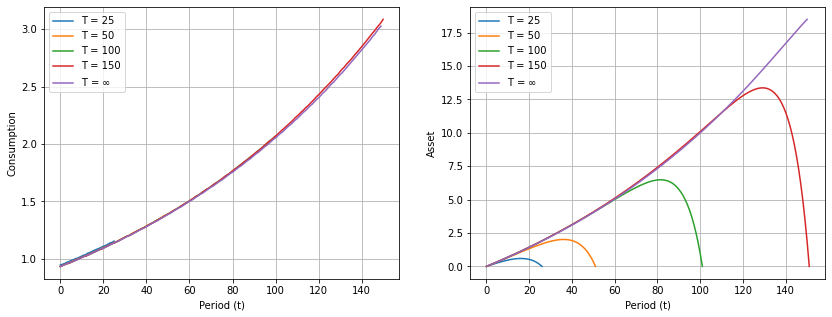

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
consum_save_paths = [ store_consum, store_assets]
ytitles = ['Consumption', 'Asset']
labels = Ts + ['$\infty$']
for ax, consum_save, ytitle in zip(axes, consum_save_paths, ytitles):
    for path, label in zip(consum_save, labels):
        ax.plot(path, label=f"T = {label}")
    ax.grid()
    ax.legend()
    ax.set(xlabel='Period (t)', ylabel=ytitle)
#axes[0].set_ylim([0, 1])

fig.savefig('HW4_Q1.png', dpi=300)

# Question 2

In [ ]:
t = 101
q_path = 1/np.cumprod(R[:t])
a_path = asset_infinite[:t]
qa_path = q_path*asset_infinite[1:(t+1)]

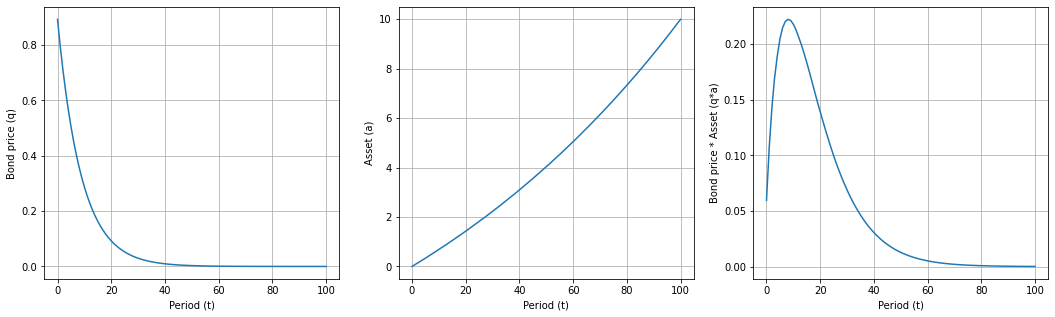

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
paths = [q_path, a_path, qa_path]
labels = ['Without retirement income', 'With tax and retirement income']
ytitles = ['Bond price (q)', 'Asset (a)', 'Bond price * Asset (q*a)']
for ax, path, ytitle in zip(axes, paths, ytitles):
    ax.plot(path)
    ax.grid()
    ax.set(xlabel='Period (t)', ylabel=ytitle)
#axes[0].set_ylim([0, 1])

fig.savefig('HW4_Q2.png', dpi=300)

# Question 3

In [ ]:
hhD = hhDecision(sigma=6)
dp3 = hhDP(hhD)
dp3.train('infinite')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in subtract


Error after 10 iterations is 50695.069161162726.
Error after 20 iterations is 45.82151664722818.
Error after 30 iterations is 6.183408825233869.
Error after 40 iterations is 1.5531724248002376.
Error after 50 iterations is 0.4546384056012016.
Error after 60 iterations is 0.1450215560726349.
Error after 70 iterations is 0.04627102263614802.
Error after 80 iterations is 0.014779784337150659.
Error after 90 iterations is 0.004724062991385836.
Error after 100 iterations is 0.0015105713367233875.


In [ ]:
tot_T = 41
consum_infinite_2 = np.zeros(tot_T)
asset_infinite_2 = np.zeros(tot_T+1)
V, P, C = dp3.find_opt_path_infinite()
for t in range(tot_T):
    asset_infinite_2[t+1] = P[np.argmin(np.abs(dp3.a_grids - asset_infinite_2[t]))]
    consum_infinite_2[t] = C[np.argmin(np.abs(dp3.a_grids - asset_infinite_2[t]))]

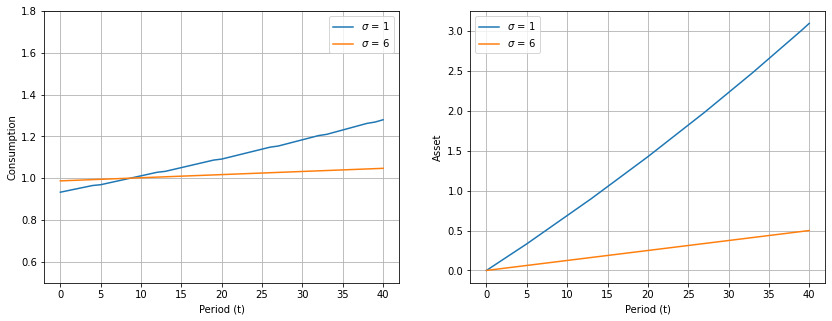

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
consum_save_paths = [ [consum_infinite[:41], consum_infinite_2],  
                      [asset_infinite[:41], asset_infinite_2[:-1]] ]
labels = ['$\sigma$ = 1', '$\sigma$ = 6']
ytitles = ['Consumption', 'Asset']
for ax, consum_save, ytitle in zip(axes, consum_save_paths, ytitles):
    for path, label in zip(consum_save, labels):
        ax.plot(path, label=label)
    ax.grid()
    ax.legend()
    ax.set(xlabel='Period (t)', ylabel=ytitle)
axes[0].set_ylim([0.5, 1.8]);

fig.savefig('HW4_Q3.png', dpi=300)

In [ ]:
import numpy as np

x = 2

1 - x/np.sqrt(3)

-0.15470053837925168

In [ ]:
2/3 - x/(2*np.sqrt(3))

0.08931639747704079

In [ ]:
4/np.sqrt(3)

2.3094010767585034

In [ ]:
np.sqrt(3)

1.7320508075688772

In [ ]:
1/3

0.3333333333333333